# Problem set 1 : Seeing in Color

#  PROBLEM 1 : color alignment

In [168]:
# setting up the environment

import numpy as np
import cv2  # if you don't have it, you can install it in anaconda prompt: pip install opencv-python
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy
import scipy.ndimage
from imageio import imread, imsave
%matplotlib inline

In [169]:
np.random.seed(0)

Image size: 370 x 370


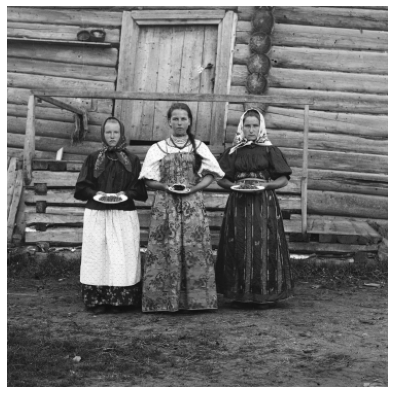

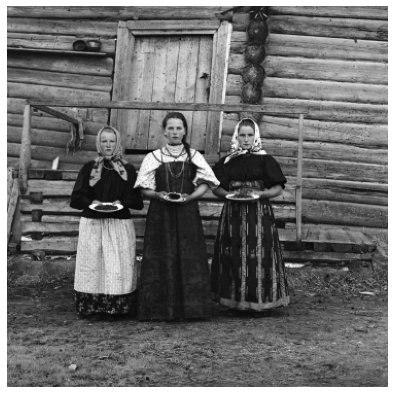

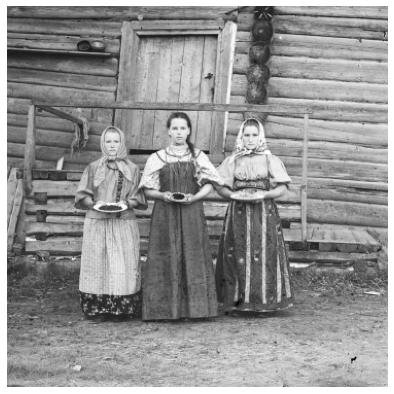

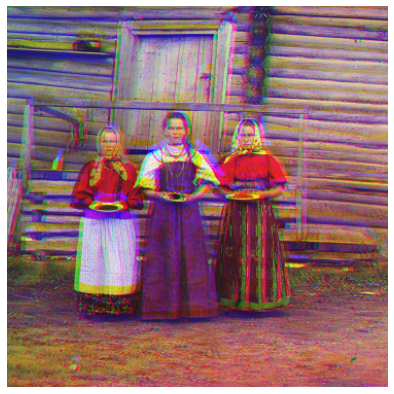

In [170]:
# reading the three color channels, and displaying them (as way as the default alignment)
red = np.array(imread('images/prokudin-girls-red.ppm',as_gray=True)/255.0)
blue = np.array(imread('images/prokudin-girls-blue.ppm',as_gray=True)/255.0)
green = np.array(imread('images/prokudin-girls-green.ppm',as_gray=True)/255.0)

print('Image size: %d x %d'% (blue.shape[0],blue.shape[1]))

# right figure size will make sure the images are displayed well, without too much aliasing or blur
plt.figure(figsize=(14,7))
plt.axis('off')
plt.imshow(blue, cmap='gray')

plt.figure(figsize=(14,7))
plt.axis('off')
plt.imshow(green, cmap='gray')

plt.figure(figsize=(14,7))
plt.axis('off')
plt.imshow(red, cmap='gray')

# now try to just superimpose the three channels; you will see significant color artifacts due to misalignment
color=np.dstack((red,green,blue))
plt.figure(figsize=(14,7))
plt.axis('off')
plt.imshow(color)

Now go ahead: implement the code for searching for the optimal alignment, and test it first on the test_image where you can introduce "synthetic" shifts, and make sure you recover from them; and then the Prokudin-Gorskii image we used above, as well as the other triplet provided (the rock image), and any additonal triplets if you would like.

## 1.1.1 Naive Stacking

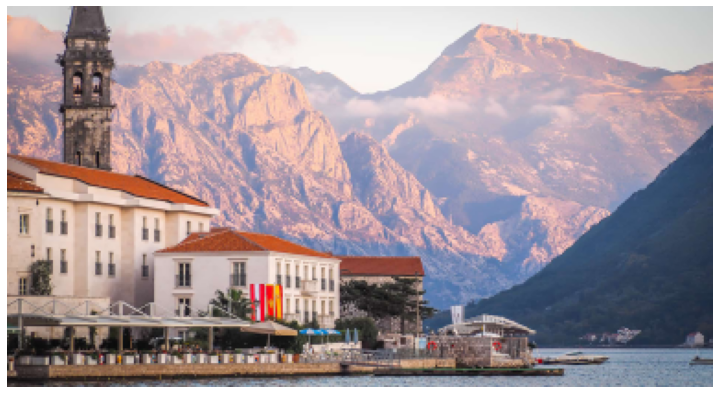

In [173]:
test = np.array(imread('images/test-image.png'))
plt.figure(figsize=(14,7))
plt.axis('off')
plt.imshow(test)

In [174]:
test_red = test[:, :, 0]
test_green = test[:, :, 1]
test_blue = test[:, :, 2]

In [175]:
def shift_channel(channel, shift_vertical, shift_horizontal):
    shifted = np.roll(channel, shift_vertical, axis=0)
    shifted = np.roll(shifted, shift_horizontal, axis=1)
    # zero-pad shifted out of bounds
    if shift_vertical > 0: # shift down
        shifted[:shift_vertical] = 0 # pad top
    elif shift_vertical < 0: # shift up
        shifted[shift_vertical:] = 0 # pad bottom
    if shift_horizontal > 0: # shift right
        shifted[:, :shift_horizontal] = 0 # pad left
    elif shift_horizontal < 0: # shift left
        shifted[:, shift_horizontal:] = 0 # pad right
    return shifted

In [176]:
SHIFT_RANGE = 15
shifts = np.random.randint(-SHIFT_RANGE, SHIFT_RANGE + 1, 4)
# green is unchanged
test_red_shifted = shift_channel(test_red, shifts[0], shifts[1])
test_blue_shifted = shift_channel(test_blue, shifts[2], shifts[3])
shifts

array([ -3,   0,   6, -15])

In [177]:
naive = np.dstack([
    test_red_shifted, 
    test_green, 
    test_blue_shifted
])

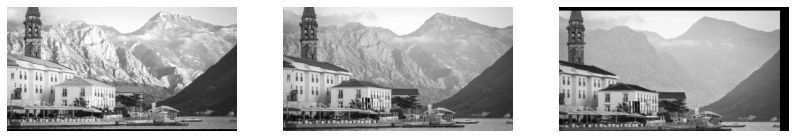

In [178]:
# side by side comparison of RGB
f, ax = plt.subplots(1, 3, figsize=(14, 7))
ax[0].imshow(test_red_shifted, cmap='gray')
ax[1].imshow(test_green, cmap='gray')
ax[2].imshow(test_blue_shifted, cmap='gray')
for a in ax:
    a.axis('off')

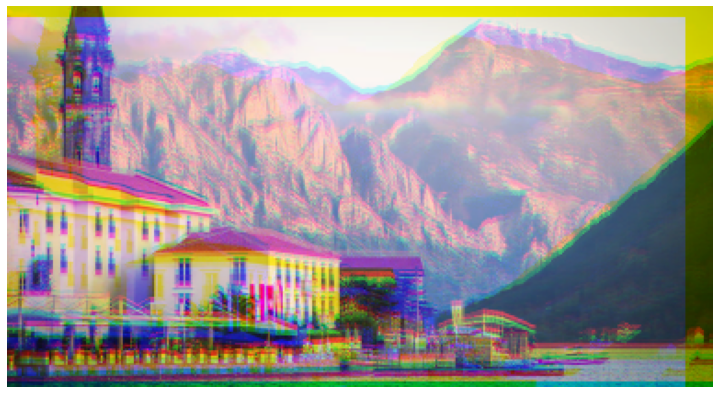

In [179]:
plt.figure(figsize=(14,7))
plt.axis('off')
plt.imshow(naive)

## 1.1.2 SSD
We should be able to align the red channel to the green channel independently from how we align the blue channel to the green channel. Therefore, we can handle the two addition components in the $\arg \min$ separately, with respect to each channel to align.

In [180]:
def align_channel_SSD(canonical, channel, search_range):
    best_score = np.inf # discrepancy
    ret = None
    for vert in range(-search_range, search_range + 1):
        for horiz in range(-search_range, search_range + 1):
            shifted = shift_channel(channel, vert, horiz)
            score = ((canonical - shifted) ** 2).sum()
            if score < best_score:
                best_score = score
                ret = (vert, horiz)
    return ret

In [181]:
align_channel_SSD(test_green, test_red_shifted, SHIFT_RANGE), \
align_channel_SSD(test_green, test_blue_shifted, SHIFT_RANGE)

((0, 1), (-6, 15))

In [208]:
def reconstruct_SSD(red, green, blue, search_range=SHIFT_RANGE):
    # use green as canonical
    offsets_red = align_channel_SSD(green, red, search_range)
    offsets_blue = align_channel_SSD(green, blue, search_range)
    aligned_red = shift_channel(red, *offsets_red)
    aligned_blue = shift_channel(blue, *offsets_blue)
    ret = np.dstack([
        aligned_red, green, aligned_blue
    ])
    return ret

In [183]:
res_SSD = reconstruct_SSD(test_red_shifted, 
                          test_green, 
                          test_blue_shifted)

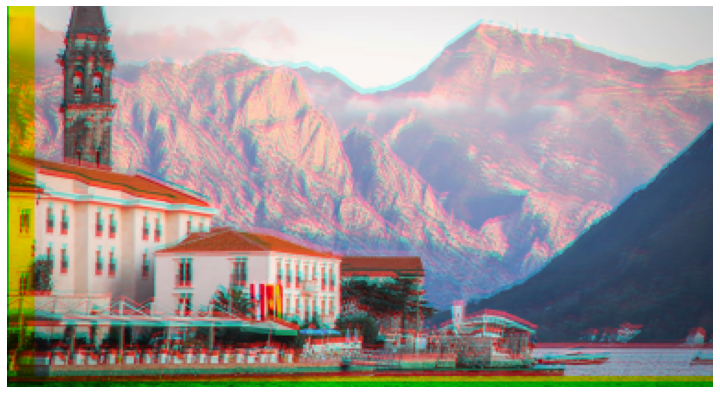

In [184]:
plt.figure(figsize=(14,7))
plt.axis('off')
plt.imshow(res_SSD)

## 1.1.3 NCC

In [185]:
def align_channel_NCC(canonical, channel, search_range):
    best_score = 0 # similarity
    ret = None
    norm_canonical = canonical / np.linalg.norm(canonical)
    for vert in range(-search_range, search_range + 1):
        for horiz in range(-search_range, search_range + 1):
            shifted = shift_channel(channel, vert, horiz)
            norm_shifted = shifted / np.linalg.norm(shifted)
            score = np.inner(norm_canonical, norm_shifted).sum()
            if score > best_score:
                best_score = score
                ret = (vert, horiz)
    return ret

In [186]:
align_channel_NCC(test_green, test_red_shifted, SHIFT_RANGE), \
align_channel_NCC(test_green, test_blue_shifted, SHIFT_RANGE)

((0, 0), (-4, 0))

In [187]:
def reconstruct_NCC(red, green, blue):
    # use green as canonical
    offsets_red = align_channel_NCC(green, red, SHIFT_RANGE)
    offsets_blue = align_channel_NCC(green, blue, SHIFT_RANGE)
    aligned_red = shift_channel(red, *offsets_red)
    aligned_blue = shift_channel(blue, *offsets_blue)
    ret = np.dstack([
        aligned_red, green, aligned_blue
    ])
    return ret

In [188]:
res_NCC = reconstruct_NCC(test_red_shifted, 
                          test_green, 
                          test_blue_shifted)

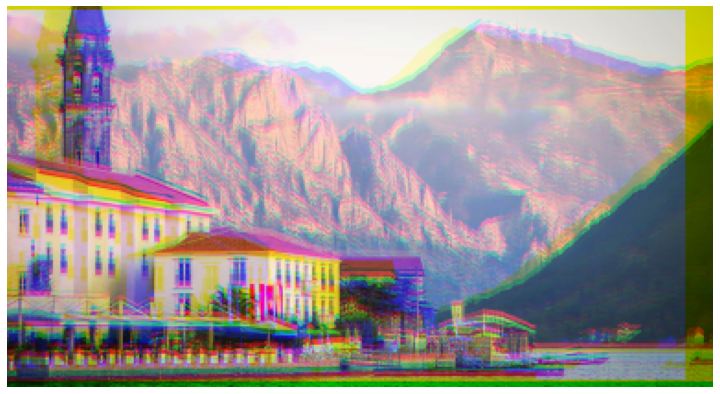

In [189]:
plt.figure(figsize=(14,7))
plt.axis('off')
plt.imshow(res_NCC)

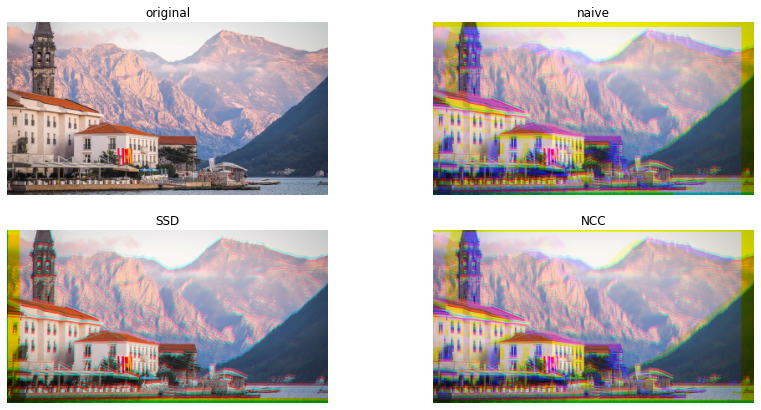

In [190]:
# side by side comparison
f, ax = plt.subplots(2, 2, figsize=(14, 7))
ax[0, 0].imshow(test)
ax[0, 0].title.set_text('original')
ax[0, 1].imshow(naive)
ax[0, 1].title.set_text('naive')
ax[1, 0].imshow(res_SSD)
ax[1, 0].title.set_text('SSD')
ax[1, 1].imshow(res_NCC)
ax[1, 1].title.set_text('NCC')
for a in ax.flatten():
    a.axis('off')

## 1.1 Conclusion

Qualitatively, the results achieved by SSD is better than that by NCC.

When we have the ground truth, we can evaluate the quality of the reconstructed image by taking the SSD (sum of squared difference) between the ground truth and the reconstruction. We sum up the difference pixel-by-pixel for each color channel.

## 1.2 Real Data

I choose to use the SSD metric.

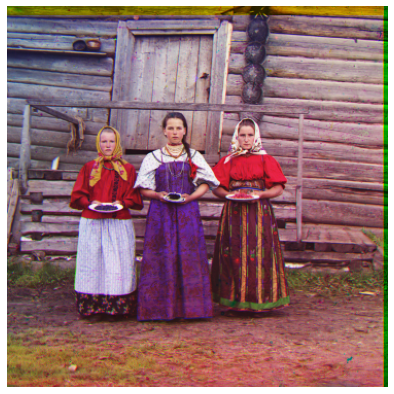

In [191]:
girls = reconstruct_SSD(red, green, blue)
plt.figure(figsize=(14,7))
plt.axis('off')
plt.imshow(girls)

In [192]:
rock_red = np.array(imread('images/prokudin-rock-red.ppm',as_gray=True)/255.0)
rock_blue = np.array(imread('images/prokudin-rock-blue.ppm',as_gray=True)/255.0)
rock_green = np.array(imread('images/prokudin-rock-green.ppm',as_gray=True)/255.0)

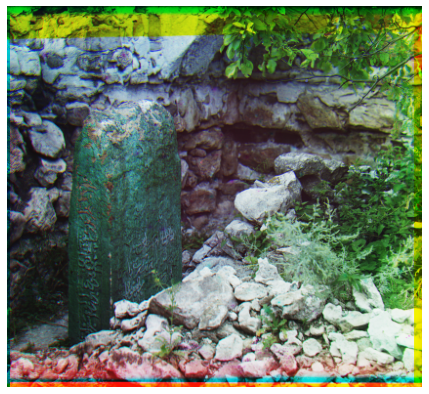

In [193]:
rock = reconstruct_SSD(rock_red, rock_green, rock_blue)
plt.figure(figsize=(14,7))
plt.axis('off')
plt.imshow(rock)

## 1.2.1 Bonus
I cropped [the image of a man](https://tile.loc.gov/storage-services/service/pnp/prok/00100/00152v.jpg) into RGB channels by hand.

In [257]:
man_red = np.array(imread('images/man-red.jpeg',as_gray=True)/255.0)
man_blue = np.array(imread('images/man-blue.jpeg',as_gray=True)/255.0)
man_green = np.array(imread('images/man-green.jpeg',as_gray=True)/255.0)

In [260]:
man_red.shape

(300, 354)

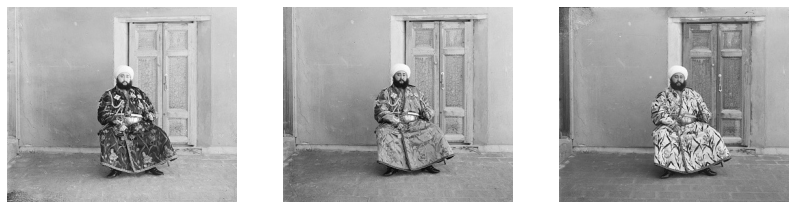

In [262]:
f, ax = plt.subplots(1, 3, figsize=(14, 7))
ax[0].imshow(man_red, cmap='gray')
ax[1].imshow(man_green, cmap='gray')
ax[2].imshow(man_blue, cmap='gray')
for a in ax:
    a.axis('off')

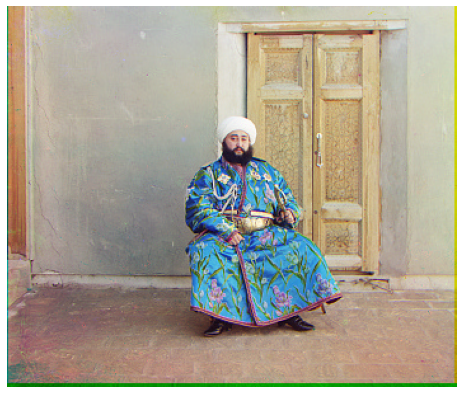

In [261]:
man = reconstruct_SSD(man_red, man_green, man_blue, search_range=20)
plt.figure(figsize=(14,7))
plt.axis('off')
plt.imshow(man)

# PROBLEM 2: Demosaicing Bayer patterns

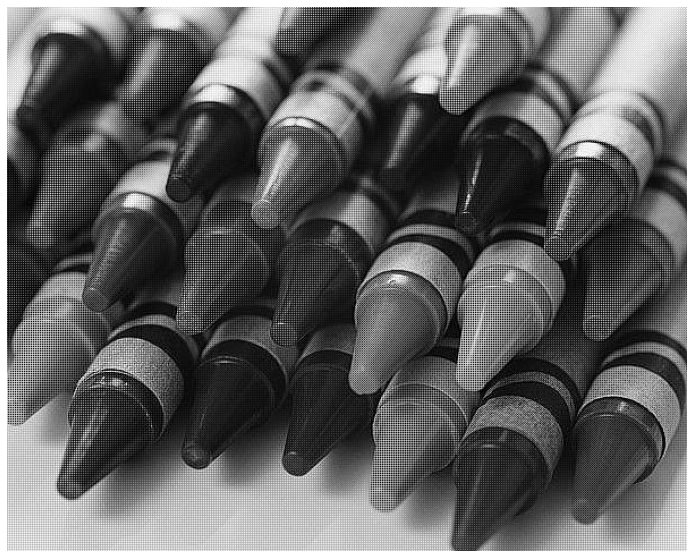

In [196]:
# we will work with this images, saved as a mosaic
# look at it first
image_path = 'images/crayons.bmp'

def read_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return image

mosaic_img = read_image(image_path)

# Visualize the mosaic; you will notice the "checkerboard" pattern 
# (you may need to make the figure larger or smaller to see it clearly)
plt.figure(figsize=(20,10))
plt.axis('off')
plt.imshow(mosaic_img, cmap='gray')        

## Naive demosaicing

Separately interpolate each color channel

In [310]:
kernel_red = np.array([
    [1, 2, 1],
    [2, 4, 2],
    [1, 2, 1]
], np.float32) / 4.
kernel_blue = kernel_red
kernel_green = np.array([
    [0, 1, 0],
    [1, 4, 1],
    [0, 1, 0]
], np.float32) / 4.

In [334]:
masked_red = mosaic_img.copy()
masked_red[1::2] = 0
masked_red[:, 1::2] = 0
interpolated_red = cv2.filter2D(masked_red, -1, kernel_red)

masked_green = mosaic_img.copy()
masked_green[::2, ::2] = 0
masked_green[1::2, 1::2] = 0
interpolated_green = cv2.filter2D(masked_green, -1, kernel_green)

masked_blue = mosaic_img.copy()
masked_blue[::2] = 0
masked_blue[:, ::2] = 0
masked_blue
interpolated_blue = cv2.filter2D(masked_blue, -1, kernel_blue)

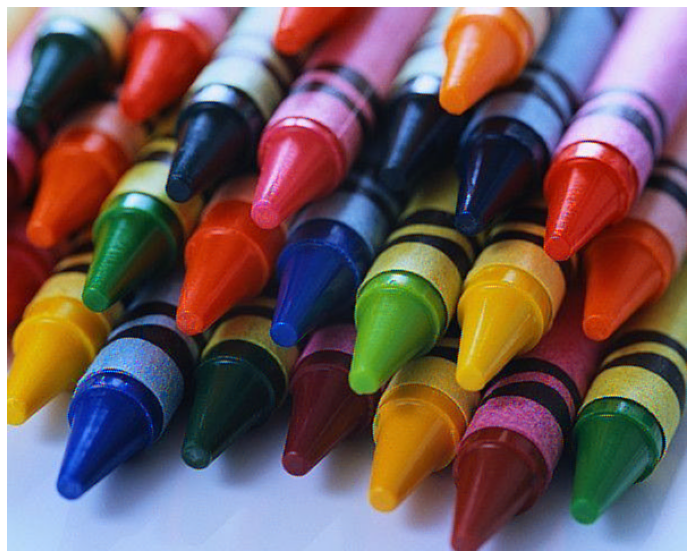

In [335]:
interpolated = np.dstack([
    interpolated_red, interpolated_green, interpolated_blue
])
plt.figure(figsize=(20,10))
plt.axis('off')
plt.imshow(interpolated)

## Freeman's Method

Tie the R and B channels to G, as described; take care to scale the color values (and then un-scale them) to make sure they have the same mean across channels.